# Explore `meta-kaggle` Dataset

## --- Synthetically Generated Data

We test the potential of our estimation algorithm by synthetically generated data.

In [ ]:
# std library
import os
import json
from pprint import pprint
from datetime import datetime, timedelta
from typing import Sequence

# third-party
from matplotlib import pyplot as plt
import numpy as np
from numpy import typing as npt
import cmdstanpy
cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel

# local
import synthetic_data as dgp

CmdStan install directory: /Users/zhuanglinsheng/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


### 1. Model Setting

In [2]:
# Capacities & Total Innovation Uncertainty
## daily based
param_c_i = 0.15
param_c_j = 0.15
param_sigma = 1.0

# Contest prize
param_theta = 1.0

# Signal Precision
param_lambda = 1.0

# Intensity-Effort Ratio
param_r = 1.5

# Contest Time Duaration
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)
contest_days = (end_time - start_time).days
contest_seconds = int((end_time - start_time).total_seconds())
contest_hours = int(contest_seconds / 3600)
contest_timegrids: list[datetime] = np.arange(start_time, end_time, \
		timedelta(hours=1), dtype=datetime).tolist()
time_unit_2f = 1 / 24

print(contest_days, contest_hours, len(contest_timegrids))

90 2160 2160


### 2. Simulations

In [3]:
time_grids, i_effort_dynamic, j_effort_dynamic, \
real_gap_dynamic, perceived_gap_dynamic, observed_gap_dynamic, \
observed_i_commits, observed_j_commits = dgp.synthetic_data_simulation(
	theta=param_theta,
	c_i=param_c_i,
	c_j=param_c_j,
	sigma=param_sigma,
	lamb=param_lambda,
	intensity_effort_ratio=param_r,
	hour_arrival_ub=1,
	start_time=start_time,
	end_time=end_time,
	time_unit=timedelta(hours=1),
	time_unit_2f=time_unit_2f,
)

In [4]:
def plot_ts_events(
		time_grids: Sequence[datetime] | npt.NDArray[np.datetime64],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		*,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios
	)
	# plot time series
	for ts_key, ts_val in ts.items():
		ax_main.plot(time_grids, ts_val, label=ts_key)
	ax_main.legend()
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1])
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height)
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

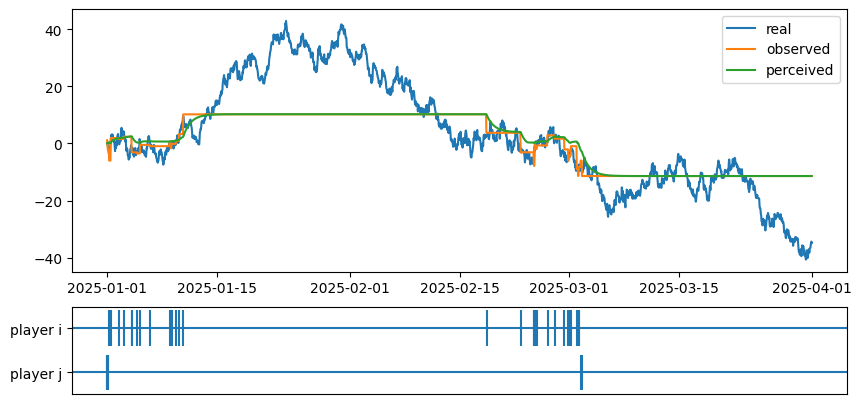

In [5]:
fig, _, _ = plot_ts_events(time_grids, {
			'real': real_gap_dynamic,
			'observed': observed_gap_dynamic,
			'perceived': perceived_gap_dynamic,
		}, {
			'player i': observed_i_commits,
			'player j': observed_j_commits,
	})

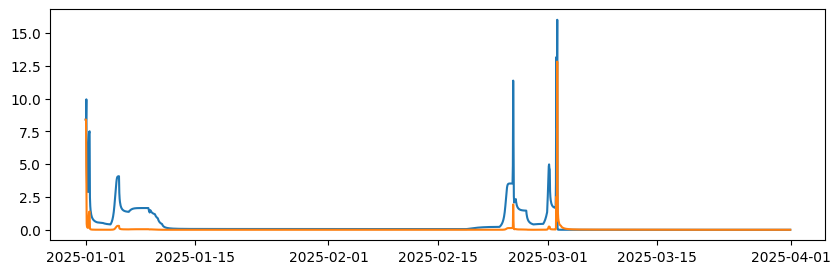

In [6]:
plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), i_effort_dynamic)
plt.plot(np.array(time_grids), j_effort_dynamic)
plt.show()

In [7]:
# save the observed data
wd = os.getcwd()
wd_synthetic_data = os.path.join(wd, 'data.json')
roundint = lambda x: int(round(x))

with open(wd_synthetic_data, 'w') as f:
	json.dump({
		'theta': param_theta,
		'T': 1 + roundint((end_time - start_time).total_seconds() / 3600),
		'Delta2f': 1/24,
		'Ni': len(observed_i_commits),
		'Nj': len(observed_j_commits),
		'hat_t_i_loc': [1 + roundint((dt - start_time).total_seconds() / 3600) for dt in observed_i_commits],
		'hat_t_j_loc': [1 + roundint((dt - start_time).total_seconds() / 3600) for dt in observed_j_commits],
		#'hat_t_i': [(dt - start_time).total_seconds() / 3600 for dt in observed_i_commits],
		#'hat_t_j': [(dt - start_time).total_seconds() / 3600 for dt in observed_j_commits],
		'hat_y': observed_gap_dynamic.tolist(),
	}, f, indent=4)

### 3. Bayesian Inference

In [8]:
# build stan model
stan_file = os.path.join(wd, 'synthetic_data.stan')
model = CmdStanModel(stan_file=stan_file)

14:41:00 - cmdstanpy - INFO - compiling stan file /Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/synthetic/synthetic_data.stan to exe file /Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/synthetic/synthetic_data
14:41:05 - cmdstanpy - INFO - compiled model executable: /Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/synthetic/synthetic_data


In [9]:
# fit the model with data
fit = model.sample( \
		data=wd_synthetic_data,
		chains=4,
		iter_warmup=2000,
		iter_sampling=4000,
		parallel_chains=4,
		show_console=False,
		max_treedepth=12,  # for difficult model
		adapt_delta=0.99,  # for difficult model
	)

14:41:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:42:39 - cmdstanpy - INFO - CmdStan done processing.


In [10]:
pprint(fit.diagnose())

('Checking sampler transitions treedepth.\n'
 'Treedepth satisfactory for all transitions.\n'
 '\n'
 'Checking sampler transitions for divergences.\n'
 'No divergent transitions found.\n'
 '\n'
 'Checking E-BFMI - sampler transitions HMC potential energy.\n'
 'E-BFMI satisfactory.\n'
 '\n'
 'Rank-normalized split effective sample size satisfactory for all '
 'parameters.\n'
 '\n'
 'Rank-normalized split R-hat values satisfactory for all parameters.\n'
 '\n'
 'Processing complete, no problems detected.\n')


True Values:
- param_c_i = 0.15
- param_c_j = 0.15
- param_sigma = 1.0
- param_lambda = 1.0
- param_r = 1.5

Estimated:

In [11]:
posteriors = fit.summary()
posteriors.iloc[1:2]

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
r,0.915456,0.001132,0.066966,0.064219,0.78469,0.930665,0.99409,2920.41,2443.16,1.00247


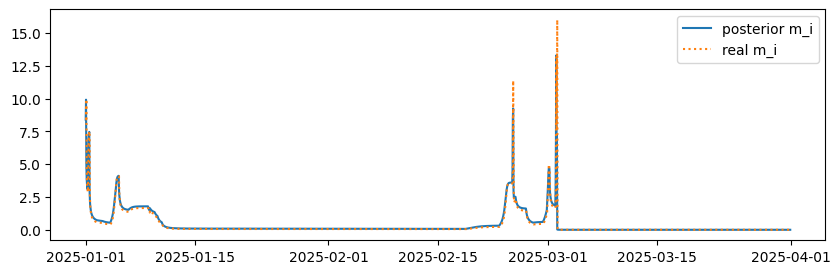

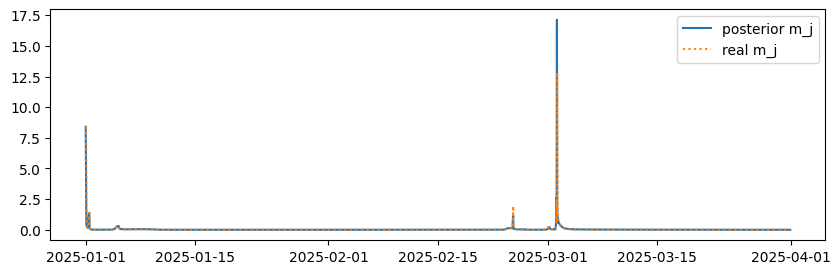

In [14]:
# compare posterior m[1]..m[T] with real
loc_m_i_ = 2
posterior_m_i_mean = posteriors['Mean'].iloc[loc_m_i_:loc_m_i_ + 2160]
loc_m_j_ = loc_m_i_ + 2161
posterior_m_j_mean = posteriors['Mean'].iloc[loc_m_j_:loc_m_j_ + 2160]

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_i_mean, label='posterior m_i')
plt.plot(np.array(time_grids), i_effort_dynamic, label='real m_i', linestyle='dotted')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_j_mean, label='posterior m_j')
plt.plot(np.array(time_grids), j_effort_dynamic, label='real m_j', linestyle='dotted')
plt.legend()
plt.show()

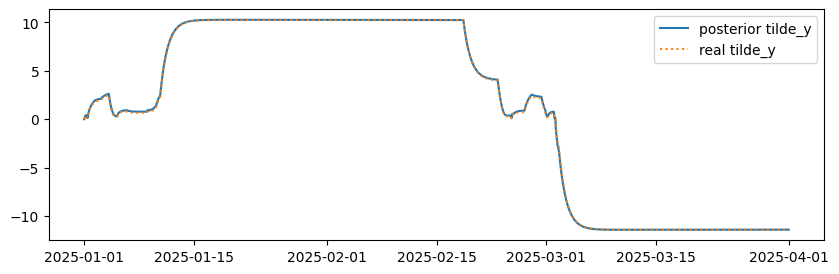

In [13]:
# compare posterior \tilde{y}[1]..\tilde{y}[T] with real
loc_tilde_y_ = loc_m_j_ + 2161
posterior_tilde_y_mean = posteriors['Mean'].iloc[loc_tilde_y_:loc_tilde_y_ + 2160]

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_tilde_y_mean, label='posterior tilde_y')
plt.plot(np.array(time_grids), perceived_gap_dynamic, label='real tilde_y', linestyle='dotted')
plt.legend()
plt.show()